# The aim of this colab is to assess wheter or not there is a problem within the optimizer itself

## How?
The idea is to initialize the optimizer with the same value used to generate the signal
## Expectation :
Fastly the optimizer should converge with a solution identical to the initialization

In [17]:
import numpy as np
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.optimizer import Optimizer
from src.online_learning.utils import load_from_yaml
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
alpha = 0.00
# optimizer_method = 'L-BFGS-B'
#optimizer_method = 'nelder-mead'
optimizer_method = 'BFGS'
#optimizer_method = 'Powell'
number_of_restarts = 1
bounds = [(0.001, 0.5), (0.001, 0.5), (800, 20000)] # left r0 was: 0.01, right rc: 100, right c: 100
#bounds = None
scale_factor = [1e-4, 1e-4, 1e3] 
# options={'disp': True}
#options={'xtol': 1e-8, 'ftol': 1e-8, 'maxiter': 10}  # Powell options
# BFGS Options
options = {
    'gtol': 1e-8,   # Gradient norm tolerance
    'eps': 1e-8,    # Step size for numerical gradient approximation
    'maxiter': 10000,  # Maximum number of iterations
    'disp': True    # Display convergence messages
} # BFGS options
initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])

In [19]:
# Load Dataframe
df = pd.read_csv('../../../data/ground/experiment_signals/dataset_0_cutted40000samples.csv')
i_real = df['current'].values
time = df['time']
    
# Load YAML:
grid_parameters = load_from_yaml('../../../data/external/ranges')
electrical_params = load_from_yaml('../../../data/external/electrical_params')
thermal_params = load_from_yaml('../../../data/external/thermal_params')
models_config = [electrical_params, thermal_params]    
battery_options = load_from_yaml('../../../data/external/battery_options')    
load_var = 'current'
    
battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var
            )


reset_info = {'electricala_params': electrical_params, 'thermal_params': thermal_params}
battery.reset(reset_info)
battery.init({'dissipated_heat' : 0 }) # check if you can remove it  
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()

#battery_results = battery.get_last_results()
optimizer = Optimizer(models_config=models_config, battery_options=battery_options, load_var=load_var,
                      init_info=reset_info, bounds=bounds, scale_factor=scale_factor, options=options)

<Axes: >

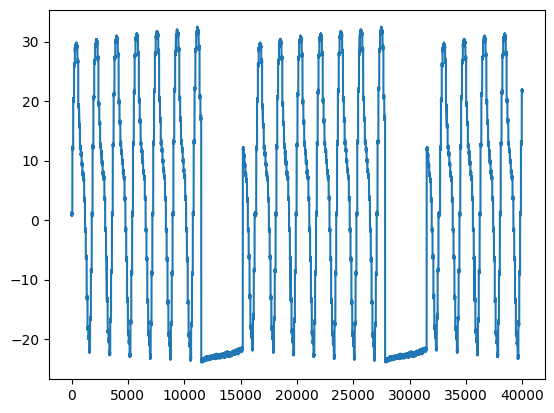

In [20]:
df['current'].plot()

Generating a Voltage signal from a fixed theta

In [21]:
for k, load in enumerate(i_real):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [22]:
print(battery.get_status_table())

{'time': 40780.0, 'soc': 0.7292712430555501, 'soh': 1.0, 'c_max': 40.0, 'voltage': 28.130175983356846, 'current': -21.656, 'power': 609.1870910955759, 'v_oc': 27.140940508916636, 'r0': 0.04, 'r1': 0.01, 'c': 10000.0, 'v_r0': -0.86624, 'v_rc': -0.12299547444021025, 'temperature': 325.5580032243768, 'heat': 20.272082113277243}


In [23]:
results = battery.build_results_table()
#print(results['operations'])
results = results['operations']
v = results['voltage']
v_real = np.array(v)
v_real = v_real[1:len(v_real)]
t = results['temperature']
t_real = np.array(t)
t_real = t_real[1:len(t_real)]

In [31]:
print(results.keys())

dict_keys(['time', 'soc', 'soh', 'c_max', 'voltage', 'current', 'power', 'v_oc', 'r0', 'r1', 'c', 'v_r0', 'v_rc', 'temperature', 'heat'])


In [24]:
r0 = battery._electrical_model.r0.resistance
rc = battery._electrical_model.rc.resistance
c = battery._electrical_model.rc.capacity
theta_to_get = {'r0':r0,'rc':rc,'c':c}
theta_values = np.array(list(theta_to_get.values()), dtype=float)

In [25]:
print('the optimizer is initialized whitin:', initial_guess)

the optimizer is initialized whitin: [1.56084597e-01 2.31910767e-01 9.00603837e+02]


In [26]:
theta = optimizer.step(i_real=i_real, v_real=v_real,
                       t_real=t_real,optimizer_method= optimizer_method,
                       alpha=alpha,dt=dt, number_of_restarts= number_of_restarts, starting_theta=initial_guess)

/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-davide/ErNESTO-DT/src/digital_twin/battery_models/electrical/ecm.py:192: RuntimeWarning: overflow encountered in double_scalars
  self.rc.get_r_series(k=k) * self.rc.get_i_r_series(k=k)**2
/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-davide/ErNESTO-DT/src/digital_twin/battery_models/thermal/r2c.py:108: RuntimeWarning: invalid value encountered in double_scalars
  t_surf = t_core + self.r_cond * (T_amb - t_core) / (self.r_cond + self.r_conv)
/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-davide/ErNESTO-DT/src/digital_twin/battery_models/electrical/ecm_components/rc_parallel.py:183: RuntimeWarning: overflow encountered in double_scalars
  i_r1 = v_rc / self.resistance
/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-davide/ErNESTO-DT/src/digital_twin/battery_models/electrical/ecm.py:159: RuntimeWarning: overflow encountered in double_scalars
  power = v * i_load
/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-davide/ErNESTO-DT/src/digital_twin/bat

















































































































































































































































































































































         Current function value: 28.652142
         Iterations: 40
         Function evaluations: 350
         Gradient evaluations: 84
<class 'list'>
[  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 28.652142153476355
        x: [ 4.006e-02  1.003e-02  1.015e+04]
      nit: 40
      jac: [ 2.530e+00 -1.557e-01  0.000e+00]
 hess_inv: [[ 5.386e-07 -4.861e-07  9.016e-01]
            [-4.861e-07  4.697e-07 -8.085e-01]
            [ 9.016e-01 -8.085e-01  1.911e+06]]
     nfev: 350
     njev: 84]


In [27]:
print("theta_dt:",theta_to_get)
print("theta_optimizer:",theta)

theta_dt: {'r0': 0.04, 'rc': 0.01, 'c': 10000.0}
theta_optimizer: {'r0': 0.040062630195748544, 'rc': 0.010033911607653332, 'c': 10145.94318011746}


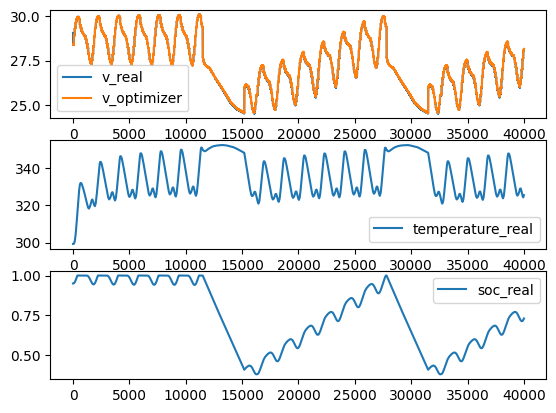

In [28]:
v_optimizer = optimizer.get_v_hat()
temp_optimizer = optimizer.get_t_hat()

# plotting phase:
results = battery.build_results_table()
results = results['operations']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plot voltage data
ax1.plot(results['voltage'], label='v_real')
#ax1.plot(df['voltage'][0:len(results['voltage'])], label='ground')
ax1.plot(v_optimizer[0:len(results['voltage'])], label='v_optimizer')
ax1.legend()

# Plot temperature data
ax2.plot(results['temperature'], label='temperature_real')
#ax2.plot(df['temperature'][0:len(results['temperature'])], label='ground')
#ax2.plot(temp_optimizer[0:len(results['temperature'])], label='temp_optimizer')
ax2.legend()

# Plot soc data
ax3.plot(results['soc'], label='soc_real')
#ax3.plot(df['soc'][0:len(results['temperature'])], label='ground')
ax3.legend()

plt.show()

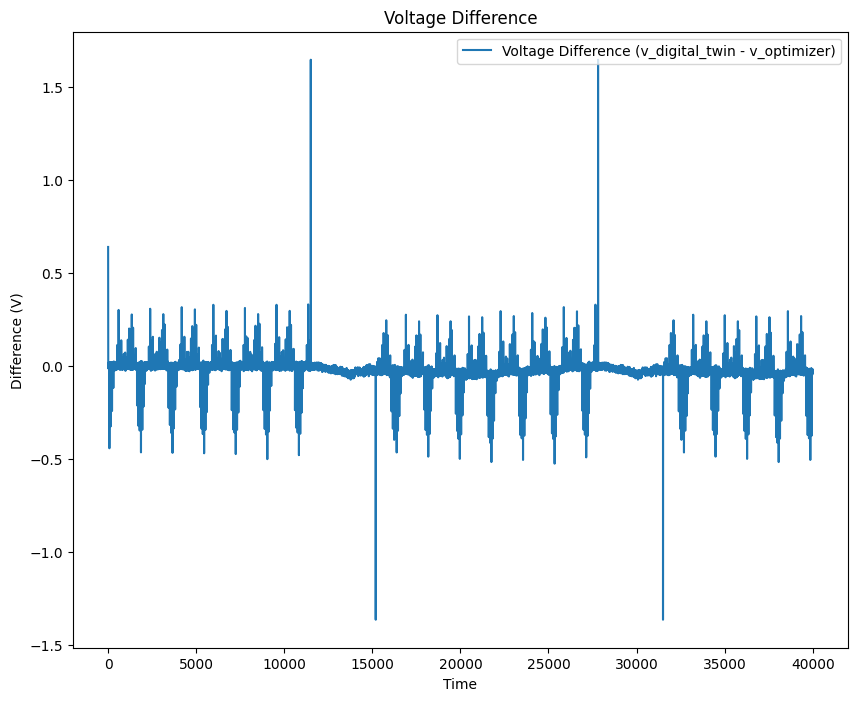

In [30]:
voltage = np.array(results['voltage'])
voltage = voltage[0:len(voltage)-1]
voltage_difference =  voltage - np.array(v_optimizer[0:len(results['voltage'])])

fig, (ax1) = plt.subplots(figsize=(10, 8))

# Plot voltage difference data
ax1.plot(voltage_difference, label='Voltage Difference (v_digital_twin - v_optimizer)')
ax1.set_title('Voltage Difference')
ax1.set_ylabel('Difference (V)')
ax1.legend()

plt.xlabel('Time')
plt.show()

# Percentage Average Error

In [37]:
voltage2 = np.array(v_optimizer[0:len(results['voltage'])])
errors = np.abs((voltage - voltage2) / voltage) * 100
value = np.mean(errors)
formatted_value = "{:.2f}".format(value)
cut_value = float(formatted_value)
formatted_value = f"{cut_value}%"
print(formatted_value)

0.09%


In [13]:
temperature = results['temperature']
temperature = temperature[0:len(temperature)-1]
temperature_difference = temperature - np.array(temp_optimizer[0:len(results['temperature'])])

# Plot temperature difference data
ax2.plot(temperature_difference, label='Temperature Difference (temperature_digital_twin - temp_optimizer)')
ax2.set_title('Temperature Difference')
ax2.set_ylabel('Difference (°C)')
ax2.legend()

plt.xlabel('Time')
plt.show()

TypeError: 'NoneType' object is not subscriptable